<a href="https://colab.research.google.com/github/ricardo-kowalski/teste/blob/master/atividade_kmeans_knn_abordagem2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio "Catch Me If You Can" #
Desafio:

* Aplicar o métodos de agrupamento k-means ao conjunto de teste;
* Treinar o conjunto de teste utilizando o algoritmo knn e as predições fornecidas pelo k-means;
* Remover as labels do conjunto de treino;
* Aplicar o método de predição knn ao conjunto de treino;
* Comparar as labels da predição com as originais;

##ABORDAGEM 2 - FALTA TERMINAR ##

Nessa abordagem estou tentando utilizar a análise e pré-processamento seguintes: https://www.kaggle.com/adityaecdrid/initial-eda

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/drive', force_remount=True)
%cd /drive/My\ Drive/CURSO I2A2/DESAFIO_KMEANS_KNN
!ls

Mounted at /drive
/drive/My Drive/CURSO I2A2/DESAFIO_KMEANS_KNN
initial-eda_teste1.ipynb  test_sessions_text.txt   versao2.ipynb
initial-eda_teste2.ipynb  train_sessions.csv	   versao3.ipynb
re-git_v4.csv		  train_sessions_text.txt  versao4.ipynb
site_dic.pkl		  Untitled0.ipynb	   versao5.ipynb
test_sessions.csv	  versao1.ipynb


In [0]:
from __future__ import division, print_function
## to ignore warnings as we don't like them as such
import warnings
warnings.filterwarnings('ignore')
#plotting lib's
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#other's
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score , roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [0]:
# Read the training and test data sets
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [0]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [0]:
train_df.get_ftype_counts()

datetime64[ns]:dense    1
float64:dense           9
int64:dense             2
object:dense            9
dtype: int64

In [0]:
test_df.get_ftype_counts()

datetime64[ns]:dense    1
float64:dense           9
int64:dense             1
object:dense            9
dtype: int64

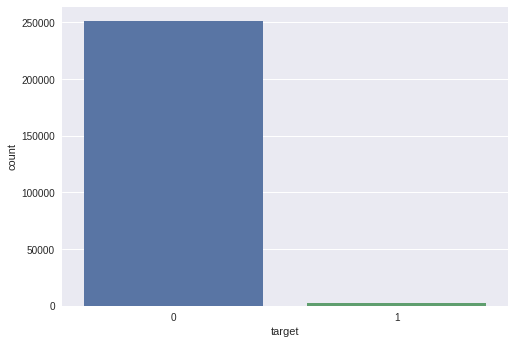

In [0]:
sns.countplot(train_df['target']) #Imbalanced Dataset

In [0]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [0]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [0]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
top_sites

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64

In [0]:
# Alice's preferences
top_sites_alice = pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten()
                           ).value_counts().sort_values(ascending=False).head()
top_sites_alice

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64

In [0]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

In [0]:
time_df_test = pd.DataFrame(index=test_df.index)

# Find sessions' starting and ending
time_df_test['min'] = test_df[times].min(axis=1)
time_df_test['max'] = test_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df_test['seconds'] = (time_df_test['max'] - time_df_test['min']) / np.timedelta64(1, 's')

- y_train - our target variable 

- full_df - the merged table of input data (training and test samples together) 

* idx_split - the index by which we will separate the training sample from the test


In [0]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

#full_df[:].fillna(method='bfill',inplace=True)

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [0]:
full_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [0]:
full_sites = full_df[sites] #only sites
full_sites.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


## Creating characteristics

- Extracting attributes from the site table 

- Count the number of unique sites in each session

In [0]:
%%time
#Getting Unique Counts
unique_count = []
for row in full_sites.values:
    unique = np.unique (row)
    if 0 in unique:
        unique_count.append(len(unique) - 1)
    else:
        unique_count.append(len(unique))
unique_count = np.array(unique_count).reshape(-1,1)

CPU times: user 5.27 s, sys: 1.32 ms, total: 5.27 s
Wall time: 5.29 s


In [0]:
unique_count[:10] #print few

array([[2],
       [2],
       [6],
       [5],
       [6],
       [5],
       [5],
       [6],
       [5],
       [8]])

In [0]:
additional_data_df  =  pd.DataFrame(data = unique_count ,columns = ['unique'],index = full_df.index ) #my features dataframe

Create a dictionary where the keys are sites, and the values ​​- the number of sessions in which this site met.

In [0]:
site_dict  =  {} 
for  row  in  full_sites . values : 
    for  site_id  in  np . unique ( row ): 
        if  site_id  in  site_dict : 
            site_dict [ site_id ]  +=  1 
        else : 
            site_dict [ site_id ]  =  1 
site_dict.pop(0)

30500

Make the presence indicator in the site of the site, which is included in the top 10 popular sites

In [0]:
%%time
top_10 = sorted (list (site_dict.items ()), key = lambda tup: tup [1], reverse = True) [: 10]
top_10 = [element [0] for element in top_10]
have_top_10 = np.zeros ((full_sites.shape [0], 1), dtype = int)
ind = 0
for row in full_sites.values:
    unique = np.unique (row)
    for site_id in unique:
        if site_id in top_10:
            have_top_10[ind] = 1
    ind += 1

have_top_10

CPU times: user 4.4 s, sys: 5.89 ms, total: 4.41 s
Wall time: 4.41 s


In [0]:
additional_data_df [ 'have_top_10' ]  =  have_top_10

In [0]:
additional_data_df.head(3)

,unique,have_top_10
session_id,,
21669,2,0
54843,2,0
77292,6,0


Count the number of absolutely unique sites in the session (the sites met only in this session)

In [0]:
absolutely_unique_count  =  np.zeros((full_sites.shape[0], 1 ), dtype = int ) 
ind  =  0 
for  row  in  full_sites . values : 
    unique  =  np . unique ( row ) 
    absolutely_unic_row  =  {} 
    for  site_id  in  unique : 
        if (site_id !=0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row ): 
            absolutely_unique_count [ ind ]  +=  1 
            absolutely_unic_row [ site_id ]  =  1 
    ind  +=  1
absolutely_unique_count

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [0]:
additional_data_df['absolutely_unique_count'] = absolutely_unique_count

Make an indicator of the presence of an absolutely unique site in the session

In [0]:
absolutely_unique = (absolutely_unique_count > 0 ).astype(int)

In [0]:
additional_data_df ['have_absolutely_unique' ] = absolutely_unique

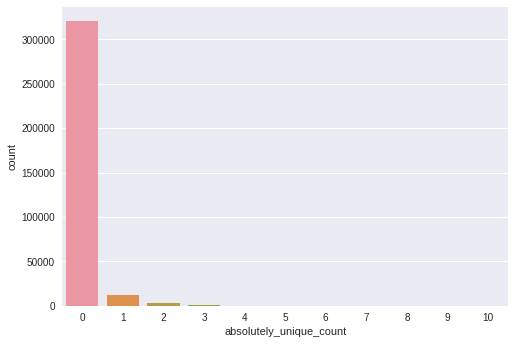

In [0]:
sns.countplot(additional_data_df['absolutely_unique_count'])

### Work over time 

- We extract a table in which there will be only columns of time

In [0]:
full_time  =  full_df[times] 
full_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


**We calculate the time of staying on each site within one session**

In [0]:
def  get_time_diff (row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length)and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i+1] - row[i]) /np.timedelta64(1,'s') 
        i += 1 
    return  time_diff

In [0]:
%%time
time_diff = []
for row in full_time.values:
    time_diff.append (get_time_diff (row))
time_diff = np.log1p(np.array(time_diff).astype(float))

CPU times: user 20.2 s, sys: 165 ms, total: 20.4 s
Wall time: 20.4 s


In [0]:
## Appending The Newly Created Features
time_names = ['time_diff'+str(j) for j in range(1,10)] 
for ind,column_name in enumerate(time_names): 
    additional_data_df[column_name] = time_diff[:,ind] 

**We will calculate the total time spent at each session**

In [0]:
def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

In [0]:
%%time
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

CPU times: user 2.46 s, sys: 11.9 ms, total: 2.47 s
Wall time: 2.48 s


In [0]:
additional_data_df['total_time'] =  total_time 
additional_data_df['total_time'] =  np.log1p(additional_data_df['total_time'].values)

In [0]:
additional_data_df['start_hour']  =  full_time['time1'].apply(lambda ts: ts.hour) 
additional_data_df['holiday']     = (full_time['time1'].dt.dayofweek >= 5).astype(int) 
additional_data_df['day_of_week'] = (full_time['time1'].dt.dayofweek).astype(int)

In [0]:
additional_data_df.head(5)

,unique,have_top_10,absolutely_unique_count,have_absolutely_unique,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,total_time,start_hour,holiday,day_of_week
session_id,,,,,,,,,,,,,,,,,
21669,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8,1,5
54843,2,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.488294,8,1,5
77292,6,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000,1.609438,8,1,5
114021,5,0,0,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147,1.386294,8,1,5
146670,6,0,0,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,1.098612,8,1,5


In [0]:
add_data_train = additional_data_df[: idx_split ].copy() 
add_data_test  = additional_data_df[ idx_split :]

### Analysis of training and test samples 

In [0]:
add_data_train.loc[:, 'target' ]= y_train

**Let's see what signs we have**

In [0]:
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

,Column_name,Column_type
0,unique,int64
1,have_top_10,int64
2,absolutely_unique_count,int64
3,have_absolutely_unique,int64
4,time_diff1,float64
5,time_diff2,float64
6,time_diff3,float64
7,time_diff4,float64
8,time_diff5,float64
9,time_diff6,float64


No handles with labels found to put in legend.


0    251264
1      2297
Name: target, dtype: int64


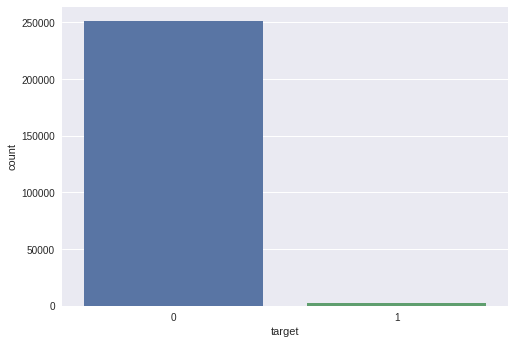

In [0]:
sns.countplot(add_data_train['target']) ;plt.legend();
print(add_data_train['target'].value_counts())

**All characteristics are of type int, but they can be divided into two groups-**
- **categorical **

- ** quantitative.**

0    251264
1      2297
Name: target, dtype: int64


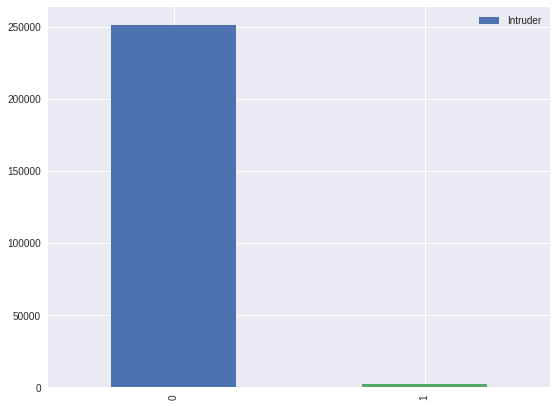

In [0]:
plt.figure(figsize=(9,7))
add_data_train['target'].value_counts().plot(kind = 'bar', label = 'Intruder')
plt.legend()
print(add_data_train['target'].value_counts())

**As you can see, we have two unbalanced classes**

**Let's look at the correlation table of the dataset**

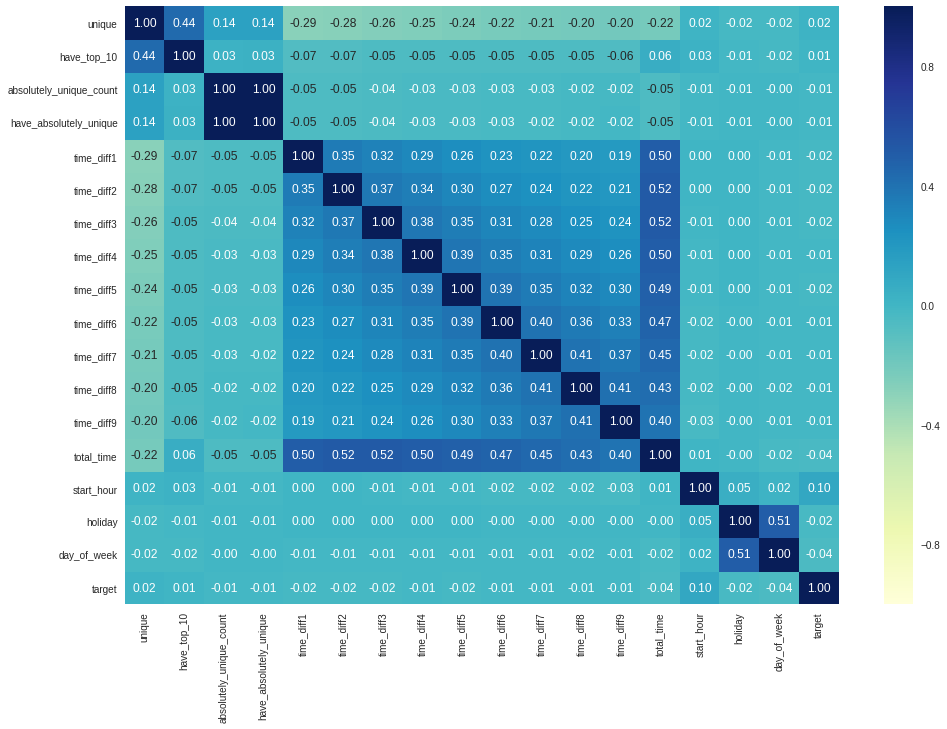

In [0]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

**Let's look at the distribution of some features**

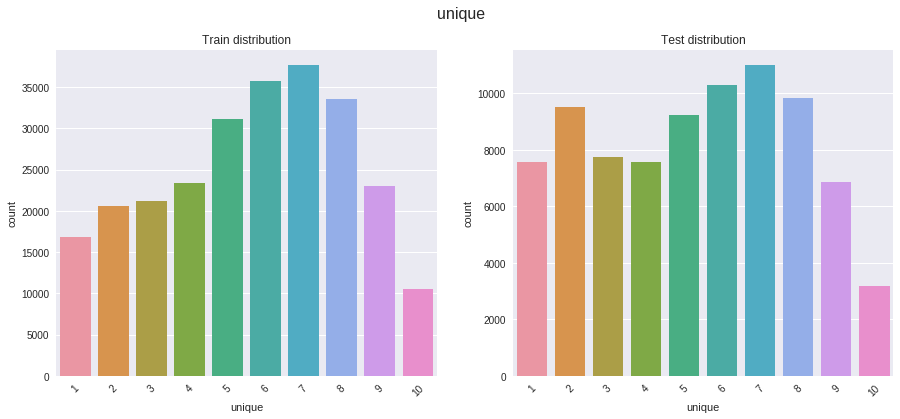

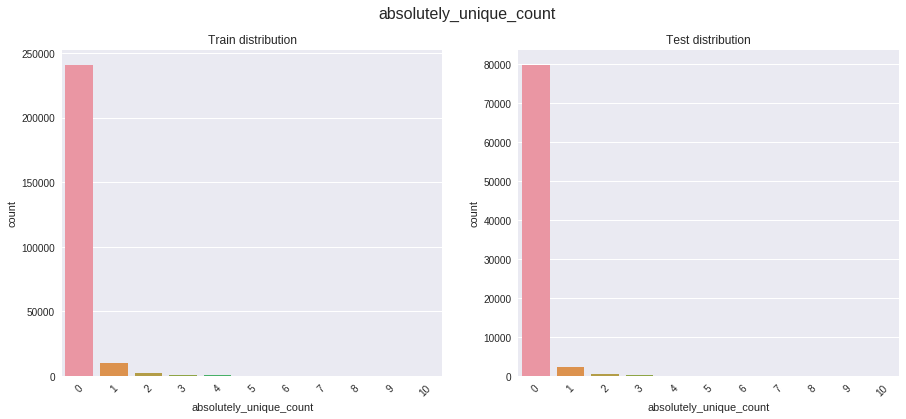

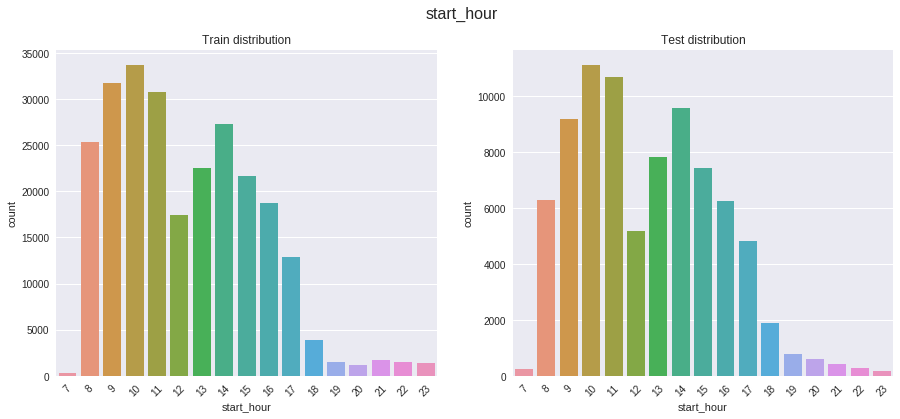

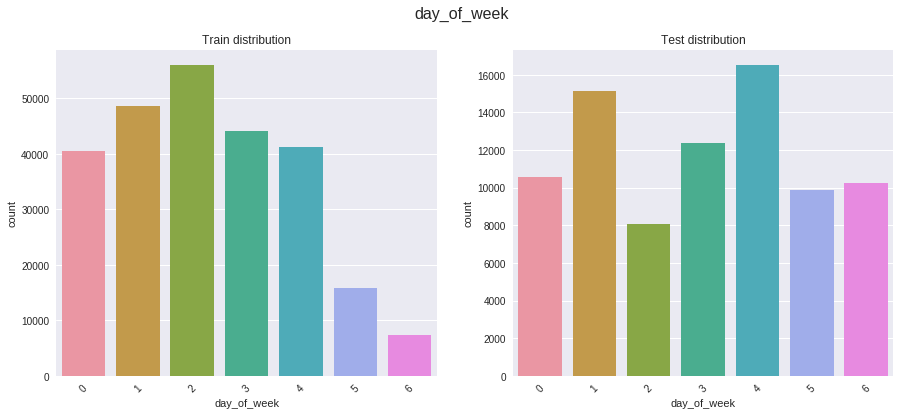

In [0]:
feature_list = ['unique','absolutely_unique_count','start_hour','day_of_week'] 
for  column_name in feature_list: 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = ( 15 , 6 )) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(add_data_train[column_name],ax=ax1) 
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(add_data_test[column_name],ax=ax2) 
    ax2.set_title("Test distribution") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

- As you can see, all the attributes are distributed approximately equally in the training and test sample. 

- The start_hour attribute is distributed from 7 to 23 hours, and not from 0 to 23 hours, as expected.

- We will analyze the effect of the characteristics on the target variable

In [0]:
def get_target_dist( column_name ): 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = (15,6)) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(add_data_train[add_data_train['target'] == 1][column_name],ax=ax1) 
    ax1.set_title("Intruder count (target: 1)") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.barplot(x=column_name,y="target",data=add_data_train,ax=ax2) 
    ax2.set_title("Intruder proportion (target: 1)") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

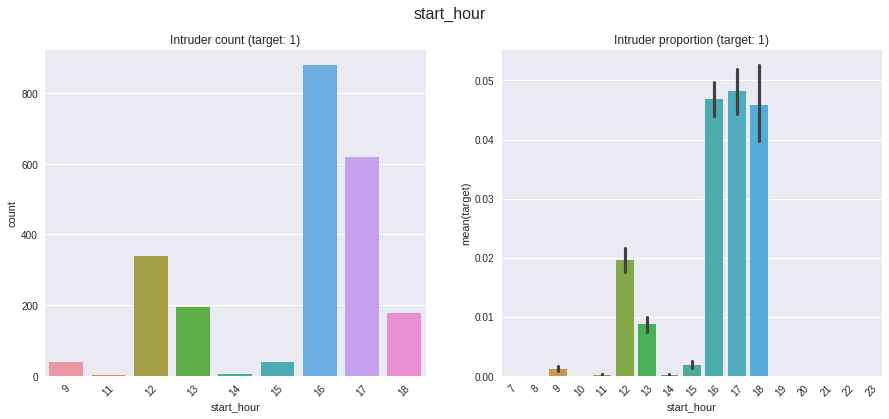

In [0]:
get_target_dist('start_hour')

Frauds were recorded between 9 and 18 hours, with the period from 16 to 18 hours most saturated with suspicious activity. On the basis of this, we will distinguish 3 features:

- morning: 7 - 11
- midday: 12 - 15
- evening: 16 - 20

In [0]:
add_data_train ['morning']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 11 )) 
add_data_train ['midday']   = add_data_train['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_train ['evening']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_train ['night']    = add_data_train['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

add_data_test ['morning']  = add_data_test['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 12 )) 
add_data_test ['midday']   = add_data_test['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_test ['evening']  = add_data_test['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_test ['night']    = add_data_test['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

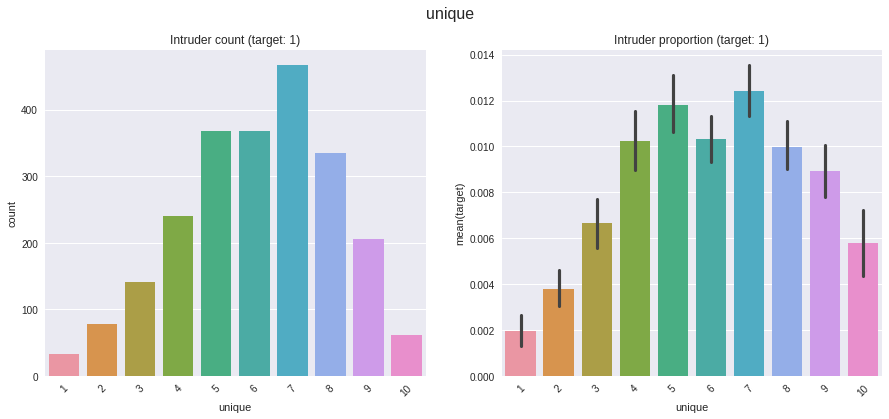

In [0]:
get_target_dist('unique')

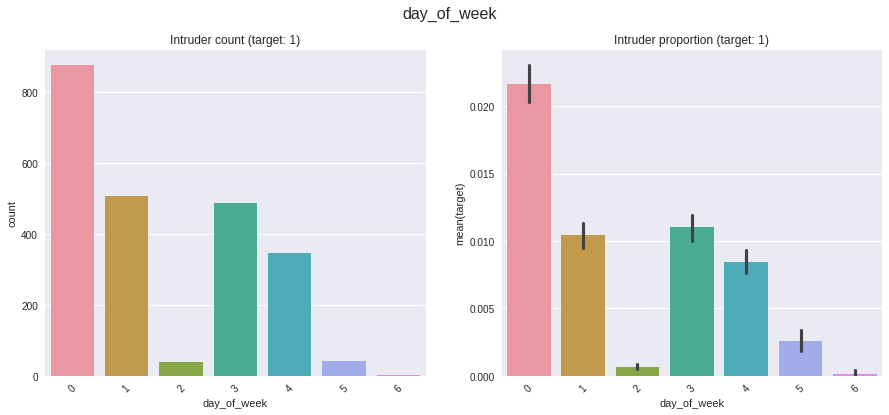

In [0]:
get_target_dist('day_of_week')

**The least suspicious activity was on Wednesdays, Saturdays and Sundays. But on Mondays(0), on the contrary, more than on other days.**

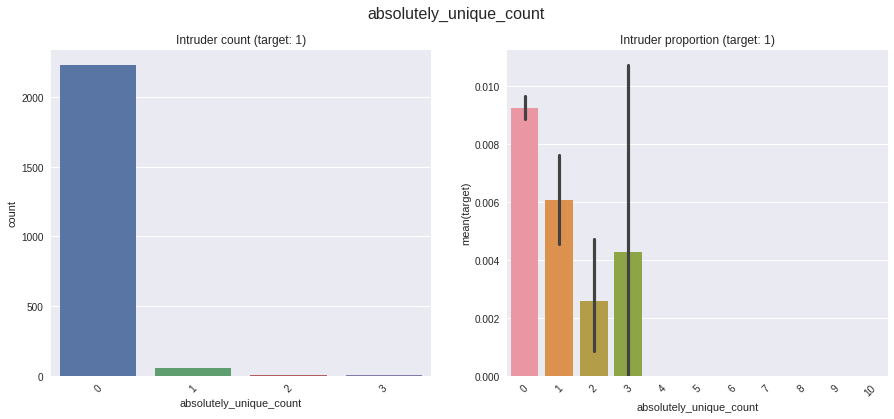

In [0]:
get_target_dist('absolutely_unique_count')

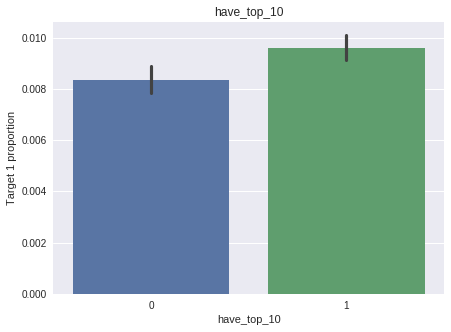

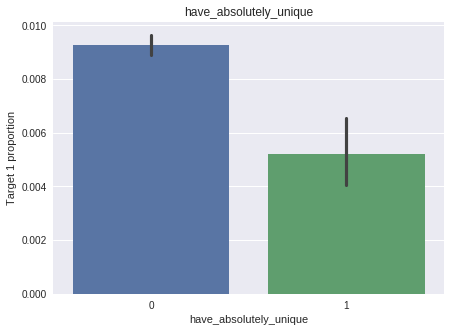

In [0]:
feature_list = ['have_top_10', 'have_absolutely_unique']
for column_name in feature_list:
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=column_name, y="target", data=add_data_train)
    ax.set(ylabel='Target 1 proportion')
    plt.title(column_name)
    plt.show()

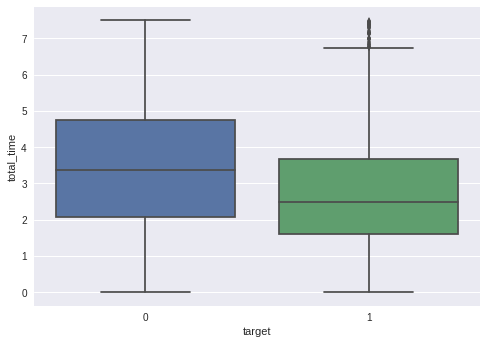

In [0]:
ax = sns.boxplot(x = 'target', y = 'total_time', data = add_data_train)

The duration of sessions with suspicious activity is on average less than that of the usual ones.

**General observations:**

- Most often, suspicious activity was seen between 16 and 18 hours
- Also on Mondays, suspicious activity occurs most often
- On average, the duration of sessions with suspicious activity is less than that of conventional
- Suspicious sessions are less common absolutely unique sites (sites that occur only once in the history of visiting sites)

### Preprocessing data 
- Convert categorical variables to dummies using get_dummies

In [0]:
add_train_dummies  = pd.get_dummies(add_data_train , columns=['day_of_week']) 
add_train_dummies.drop(['target'],axis = 1,inplace=True) 
add_test_dummies  = pd.get_dummies(add_data_test,columns=['day_of_week'])

In [0]:
idx_split

253561

In [0]:
names_for_scale  =  ['time_diff' + str(x) for x in range (1,10)]  +  ['unique','absolutely_unique_count','total_time'] 
scaler = StandardScaler() 
for column_name in names_for_scale : 
    add_train_dummies[column_name] =scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1,1)) 
    add_test_dummies[column_name]  =scaler.transform(add_test_dummies[column_name].values.reshape(-1,1))

In [0]:
# Sequence with indexes 
sites_flatten = full_sites.values.flatten()
# 
full_sites_sparse=csr_matrix(([1]  *  sites_flatten . shape [ 0 ], sites_flatten ,  
                                range(0,sites_flatten.shape[0]+10,10)))[:,1:]

X_train_sparse  =  full_sites_sparse [: idx_split ] 
X_test_sparse  =  full_sites_sparse [ idx_split :] 
full_sites_sparse.shape #(336358, 48371)

(336358, 48371)

In [0]:
full_sites = full_df[sites].astype('str')
lst = full_sites[sites].as_matrix().tolist()
flat_list = [' '.join(sublist) for sublist in lst]
vect = TfidfVectorizer(ngram_range=(1,4), max_features=100000,analyzer='char_wb')
tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf  = tfidf_matrix[idx_split:]

X_train_tf.shape, X_test_tf.shape

((253561, 13321), (82797, 13321))

**Combine the site matrix and additional features**

In [0]:
x_train_full  =  csr_matrix(hstack([X_train_tf,add_train_dummies.values])) 
x_test_full   =  csr_matrix(hstack([X_test_tf ,add_test_dummies.values])) 
x_train_full.shape,x_test_full.shape

((253561, 13348), (82797, 13348))

![Image](https://hsto.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png)



---



---



In [0]:
from sklearn import cluster
from matplotlib import pyplot

kmeans = cluster.KMeans(n_clusters = 2)
kmeans.fit(x_test_full)
labels = kmeans.labels_

In [0]:
labels #pode ser que os zeros e uns estejam invertidos

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [0]:
X_test , X_valid , y_test , y_valid = train_test_split(x_test_full, labels ,test_size=0.2) 

tscv = TimeSeriesSplit(n_splits = 10);

In [0]:
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

In [0]:
[(el[0].shape, el[1].shape) for el in tscv.split(X_test)]

[((6027,), (6021,)),
 ((12048,), (6021,)),
 ((18069,), (6021,)),
 ((24090,), (6021,)),
 ((30111,), (6021,)),
 ((36132,), (6021,)),
 ((42153,), (6021,)),
 ((48174,), (6021,)),
 ((54195,), (6021,)),
 ((60216,), (6021,))]

**Since our classes are highly unbalanced, the accuracy metric here does not fit.**

**We will use ROC_AUC as a metric, and also look at the results of confusion_matrix**

---



---



In [0]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# subsetting just the odd ones
neighbors = [1,3,5,7,9,11,13,15]     #TESTE COM 8 VALORES APENAS


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_test_full, labels, cv = tscv, scoring='roc_auc') #não tenho certeza se uso x_test_full ou X_test
    cv_scores.append(scores.mean())

CPU times: user 1h 1min 37s, sys: 8.72 s, total: 1h 1min 46s
Wall time: 1h 1min 49s


[0.9950504043013924, 0.9996908570823418, 0.9999362812441343, 0.999986385172978, 0.99999043572776, 0.9999907108347031, 0.9999925591034732, 0.9999929336693526]

The optimal number of neighbors is 15


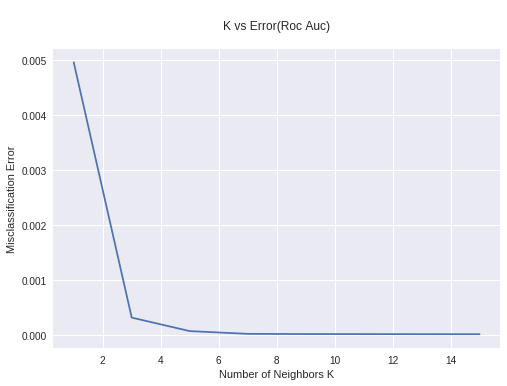

In [0]:
print(cv_scores)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("\nThe optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.title('\nK vs Error(Roc Auc)\n')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [0]:
%%time

#KNN OPTIMAL

knn_opt = KNeighborsClassifier(n_neighbors = optimal_k)

knn_opt.fit(X_test, y_test)

preds_knn = knn_opt.predict_proba(X_valid)[:, 1]

cross_score_knn = np.mean(cross_val_score(knn_opt, x_test_full, labels, cv = tscv, scoring='roc_auc')) 


CPU times: user 10min 33s, sys: 1.23 s, total: 10min 34s
Wall time: 10min 34s


In [0]:
print ('Train test split KNN score:% s ROC AUC' % round (roc_auc_score(y_valid, preds_knn), 4))  
print ('Cross validation KNN score:% s ROC AUC' % round (np.mean(cross_score_knn), 4))

Train test split KNN score:1.0 ROC AUC
Cross validation KNN score:1.0 ROC AUC


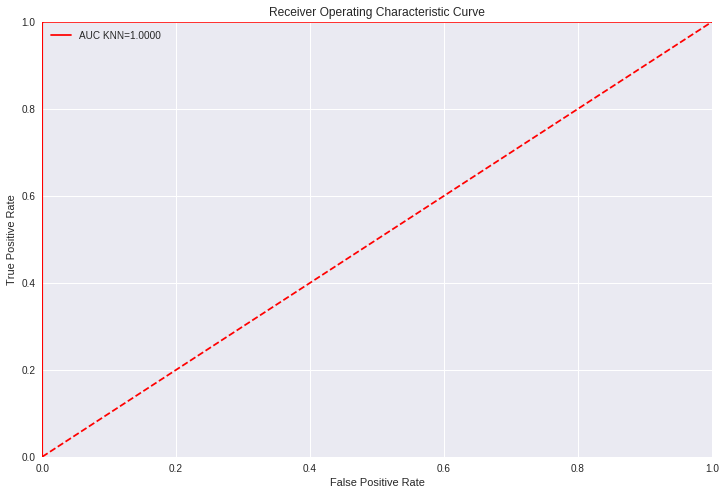

In [0]:
fpr,tpr,threshold = roc_curve(y_valid,preds_knn)
roc_auc_knn = auc(fpr,tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr,'r', label='AUC KNN=%0.4f'%roc_auc_knn)
plt.legend(loc='lowerright')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');



---

DEU RUIM << refazer

talvez um bom modo seja renomear os dataframes de treino e teste conforme o desafio, talvez isso ajude a entender as técnicas e aplicá-las de modo correto acima

---



In [0]:
'''
target = train_df['target']

X_train , Xt_valid , yt_train , yt_valid = train_test_split(x_train_full, target, test_size=0.2) 

tscv_t = TimeSeriesSplit(n_splits = 10);
'''


In [0]:
''' ARRUMAR
%%time

#KNN OPTIMAL

knn_2 = KNeighborsClassifier(n_neighbors = 3)

knn_2.fit(x_train_full, y_test)

preds_knn_2 = knn_2.predict_proba(X_valid)[:, 1]

cross_score_knn_2 = np.mean(cross_val_score(knn_2, x_train_full, labels, cv = tscv, scoring='roc_auc'))

'''

In [0]:
def show_confusion_matrix(y_true,y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true.values, y_pred)
    fig,ax=plt.subplots(frameon=False)
    fig.set_size_inches(4,3)
    fig.suptitle(title,fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5]*len([0,1]),
                        rowLabels=['True 0','True 1'],colLabels=['Predicted 0','Predicted 1'],
                        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1,4)
    plt.show()

In [0]:
show_confusion_matrix(y_valid, knn_opt.predict(X_valid))

AttributeError: ignored



---

MODIFICADO ^


---

